In [ ]:
run_config = {
    "look-back" :2,
    "learning-rate" : 0.01,
    "label-key" : "is_anomolous",
    "test-percentage" : 0.20,
    "validation-percentage" : 0.20,
    "local-epochs" : 3,
    "num-server-rounds": 13,
    "batch-size" : 128,
    "verbose" : False,
    "data-dir" : "datasets/Behacom",
    "anomaly-percentage-target":.1,
    "normalization_winsorization-outlier-threshold": 2,
    "normalization_winsorization-enable": False,
    "normalization_winsorization-bounds": 0.1,
    "accuracy-threshold": 0.7,
    "num-clients": 12,
    "client-sample":0.25,
    "dp_enable": False,
    "dp_noise-multiplier":1.1,
    "dp_clipping-norm":1.2    
}

In [2]:
import numpy as np 
import os
from typing import List

def load_files(directory: str) -> List[str]:
    file_paths = np.array([])
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.csv'):
                file_paths = np.append(file_paths, os.path.join(root, file))
    return file_paths


In [3]:
import pandas as pd 
from typing import Tuple

# Constants for the column names
timestamp_key = 'timestamp'
unix_timestamp_key = 'unix_timestamp'

def load_data(file0: str, file1: str, label_key: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Load benign and anomalous datasets, label them, and parse timestamps."""
    
    # Load the CSV files
    benign = pd.read_csv(file0, encoding='latin-1')
    anomalous = pd.read_csv(file1, encoding='latin-1')
    
    # Assign labels to the datasets
    benign[label_key] = 0
    anomalous[label_key] = 1
    
    # Convert 'timestamp' to datetime and create 'unix_timestamp' as a copy
    benign[unix_timestamp_key] = benign[timestamp_key]
    anomalous[unix_timestamp_key] = anomalous[timestamp_key]
    
    benign[timestamp_key] = pd.to_datetime(benign[timestamp_key], unit='ms')
    anomalous[timestamp_key] = pd.to_datetime(anomalous[timestamp_key], unit='ms')
    
    print(f'Loaded benign: {benign.shape}, Loaded anomalies: {anomalous.shape}')
    
    return benign, anomalous

In [4]:
from datetime import timedelta, datetime
import numpy as np
import pandas as pd
from typing import Tuple

np.random.seed(42)

def random_time_range(anomalous: pd.DataFrame, iteration: int, verbose: bool = False) -> Tuple[datetime, datetime]:
    """
    Generate a random time range within the given anomalies DataFrame, with the range 
    weighted by the number of iterations.

    Parameters:
    - anomalous: A DataFrame containing the 'timestamp' column.
    - iteration: The current iteration number used to adjust the time delta.
    - verbose: If true, prints details of the selected time range.

    Returns:
    - A tuple containing the random start and end datetime.
    """
    # Calculate the start and end times, ensuring the start time includes the real start point
    start_time, end_time = anomalous[timestamp_key].min() - timedelta(seconds=1), anomalous[timestamp_key].max()

    if verbose:
        print(f'Anomalous time range: {start_time} - {end_time}')

    # Calculate a time delta based on the iteration number (the delta grows with more iterations)
    delta = timedelta(minutes=np.random.randint(5, 30) + 1.25 ** iteration)

    # Ensure the random start time does not exceed the latest valid start time
    latest_start = max(end_time - delta, start_time)

    # Select a random start time within the range [start_time, latest_start]
    random_start = start_time + timedelta(seconds=np.random.randint(0, int((latest_start - start_time).total_seconds() + 1)))

    # Calculate the random end time based on the random start time and delta
    random_end = random_start + delta

    if verbose:
        print(f'Random time range selected: {random_start} - {random_end}')

    return random_start, random_end


In [5]:
import pandas as pd
from datetime import datetime
from typing import Tuple

def inject_anomalies(
    benign: pd.DataFrame, 
    anomalous: pd.DataFrame, 
    start_time: datetime, 
    end_time: datetime, 
    verbose: bool = False
) -> Tuple[pd.DataFrame, pd.Index]:
    """
    Inject anomalous data into a benign dataset within a specific time range.
    
    Parameters:
    - benign: The DataFrame containing benign data (normal data).
    - anomalous: The DataFrame containing anomalous data (anomalies).
    - start_time: The start time of the range in which to inject anomalies.
    - end_time: The end time of the range in which to inject anomalies.
    - verbose: If true, prints additional information about the process.
    
    Returns:
    - A tuple containing:
      - A DataFrame with anomalies injected into the benign data.
      - The indices of the injected anomalies.
    """
    # Filter anomalies and benign data within the time range
    anomalous_condition = (start_time <= anomalous[timestamp_key]) & (anomalous[timestamp_key] <= end_time)
    benign_condition = (start_time <= benign[timestamp_key]) & (benign[timestamp_key] <= end_time)
    
    subset_anomalous = anomalous[anomalous_condition]
    subset_benign = benign[benign_condition]
    index = subset_anomalous.index

    if verbose:
        print(f'{subset_anomalous.shape[0]} anomalies selected')

    # If no anomalies are found, return the original benign data
    if subset_anomalous.empty:
        return benign, index

    # If no benign data within the range, append anomalies
    if subset_benign.empty:
        if verbose:
            print('No normal data within range, appending anomalies')
        return pd.concat([benign, subset_anomalous], ignore_index=True), index

    # If benign data is found, remove it and append anomalies to prevent unrealistic data
    if verbose:
        print(f'{subset_benign.shape[0]} benign entries selected to be overwritten')

    # Remove benign data within the time range and append anomalies
    benign_to_remove = benign[
        (subset_anomalous[timestamp_key].min() <= benign[timestamp_key]) & 
        (subset_anomalous[timestamp_key].max() >= benign[timestamp_key])
    ].index

    benign_updated = benign.drop(benign_to_remove)
    updated_benign = pd.concat([benign_updated, subset_anomalous], ignore_index=True)
    
    return updated_benign, index


In [6]:
import pandas as pd
from typing import Tuple

def merge_data(
    benign: pd.DataFrame, 
    anomalies: pd.DataFrame, 
    label_key: str, 
    anomaly_percentage_target: float = 0.05, 
    verbose: bool = False
) -> Tuple[pd.DataFrame, float]:
    """
    Merge benign and anomalous datasets while targeting a specific anomaly percentage in the merged data.
    
    Parameters:
    - benign: DataFrame containing the benign data (normal data).
    - anomalies: DataFrame containing anomalous data (outliers).
    - label_key: The column name in 'benign' used for labeling anomalies.
    - anomaly_percentage_target: The target percentage of anomalies in the merged dataset.
    - verbose: If true, prints additional information during the merging process.
    
    Returns:
    - A tuple containing:
      - The merged DataFrame with anomalies injected.
      - The final anomaly percentage in the merged dataset.
    """
    print("Merging datasets...")

    max_size = benign.shape[0] + anomalies.shape[0]
    anomaly_percentage = 0
    iteration = 0

    # Merge datasets until the target anomaly percentage is reached or the size limit is hit
    while anomaly_percentage < anomaly_percentage_target and benign.shape[0] < max_size and not anomalies.empty:
        iteration += 1
        
        # Verbose logging
        if verbose:
            print(f'Iteration {iteration}: Anomalies left: {anomalies.shape[0]}, '
                  f'Anomaly percentage: {anomaly_percentage:.2%}, '
                  f'Benign size: {benign.shape[0]}, Max size: {max_size}')
            print(f'Starting shape: {benign.shape}')
        
        # Inject anomalies into the benign data within the selected time range
        benign, index = inject_anomalies(benign, anomalies, *random_time_range(anomalies, iteration))
        anomalies.drop(index, inplace=True)  # Remove injected anomalies
        
        # Verbose logging after modification
        if verbose:
            print(f'Ending shape: {benign.shape}')
        
        # Recalculate the anomaly percentage
        anomaly_percentage = benign[benign[label_key] == 1].shape[0] / benign.shape[0]

    # Final verbose output and return the merged data
    print(f'Total iterations: {iteration}, Final anomaly percentage: {anomaly_percentage:.2%}')
    print(f'Merged shape: {benign.shape}')

    return benign.sort_values(timestamp_key), anomaly_percentage


In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from typing import List
from scipy.stats import mstats, zscore


def reduce_dimensions(data: pd.DataFrame) -> pd.DataFrame:
    """Remove unnecessary columns from the dataset."""
    columns_to_drop = [timestamp_key, 'USER']
    return data.drop(columns=columns_to_drop, errors='ignore')


def encode_features(data: pd.DataFrame, verbose: bool = False) -> pd.DataFrame:
    """Encode categorical features in the dataset using Label Encoding."""
    string_columns = data.select_dtypes(include=['object']).columns
    label_encoder = LabelEncoder()
    
    for column in string_columns:
        if verbose:
            print(f"Encoding feature: {column}")
        data[column] = label_encoder.fit_transform(data[column])
    
    return data


def detect_outliers(data: pd.DataFrame, name: str, threshold: float = 3, verbose: bool = False) -> bool:
    """Detect outliers in a specified feature using z-scores."""
    column = data[name].astype(float)
    z_scores = np.abs(zscore(column))
    outliers = z_scores > threshold
    if verbose and outliers.any():
        print(f"Outliers detected in feature {name}")
    
    return outliers.any()


def winsorize_features(data: pd.DataFrame, label_key: str, outlier_threshold: int, winsorization_bounds: Tuple[float,float], verbose: bool = False) -> pd.DataFrame:
    """Winsorize features to limit outliers to the 5th and 95th percentiles."""
    print("Winsorizing features if outliers are detected")
    
    for column in data.columns:
        if column == label_key or column == unix_timestamp_key:
            continue
        
        if detect_outliers(data, column, threshold=outlier_threshold ,verbose=verbose):
            if verbose:
                print(f"Outliers found in feature {column}. Winsorizing.")
            data[column] = mstats.winsorize(data[column], limits=winsorization_bounds)
    
    return data


In [8]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from typing import Tuple

def normalize_data(data: pd.DataFrame, label_key: str) -> Tuple[np.ndarray, np.ndarray]:
    # Split the data into features and labels
    user_mask = data.columns.isin([label_key])
    features = data.iloc[:, ~user_mask].to_numpy()
    labels = data.iloc[:, user_mask].to_numpy()
    
    # Normalize features
    scaler = MinMaxScaler()
    features_scaled = scaler.fit_transform(features)
    
    return features_scaled, labels

  

In [9]:
import numpy as np
from flwr_datasets import FederatedDataset

# Custom Federated Dataset
class BehacomFederatedDataset(FederatedDataset):
    """
    Custom Federated Dataset for Behacom, inheriting from FederatedDataset.
    This class loads and processes datasets for federated learning.
    """
    def __init__(self, directory: str, label_key: str, winsorize_features: bool, outlier_threshold: int,  winsorization_bounds: Tuple[float,float], **kwargs):
        """
        Initializes the BehacomFederatedDataset by loading the files from a directory.

        Parameters:
        - directory (str): Path to the directory containing the data files.
        - label_key (str): The key in the dataset that represents the labels.
        """
        self.label_key = label_key
        self.file_paths = load_files(directory)
        self.total_files = len(self.file_paths)
        self.winsorize = winsorize_features
        self.winsorization_bounds = winsorization_bounds
        self.outlier_threshold = outlier_threshold

        if self.total_files == 0:
            raise ValueError(f"No files loaded from directory: {directory}")

    def __getitem__(self, idx: int):
        """
        Retrieves the data for a specific client based on the provided index.

        Parameters:
        - idx (int): The index of the client (or file) to fetch the data for.

        Returns:
        - tuple: (anomaly_percentage, processed_data)
            - anomaly_percentage (float): Percentage of anomalies in the merged dataset.
            - processed_data (pd.DataFrame): Processed data after encoding, feature reduction, and winsorizing.
        """
        # Randomly select another client that isn't the current one
        j = np.random.choice([i for i in range(self.total_files) if i != idx])
        
        # Load and merge benign and anomalous data
        benign_path, anomalous_path = self.file_paths[idx], self.file_paths[j]
        benign, anomalous = load_data(benign_path, anomalous_path, self.label_key)
        merged, anomaly_percentage = merge_data(benign, anomalous, self.label_key)

        # Process the merged data (encoding, dimensionality reduction, and winsorization)
        processed_data = encode_features(reduce_dimensions(merged))
        
        if self.winsorize:
            processed_data = winsorize_features(processed_data, self.label_key, self.outlier_threshold, self.winsorization_bounds)

        return anomaly_percentage, processed_data

    def __len__(self):
        """
        Returns the number of clients (i.e., total number of files).

        Returns:
        - int: The total number of files (clients).
        """
        return self.total_files


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy, Recall, Precision, TruePositives, TrueNegatives, FalseNegatives, FalsePositives, AUC, F1Score


def load_model(features_count: int, look_back: int, learning_rate: float, accuracy_threshold: float = 0.5, verbose: bool = False):
    """
    Load and compile an LSTM model with a Bidirectional architecture.

    Parameters:
    - features_count (int): The number of input features (e.g., number of columns in the dataset).
    - look_back (int): The number of time steps to look back for each sequence.
    - learning_rate (float): The learning rate for the Adam optimizer.
    - verbose (bool, optional): Whether to print the model summary. Defaults to 0.

    Returns:
    - model: A compiled Keras Sequential model ready for training.
    """
    model = Sequential([
        Input(shape=(look_back, features_count)),
        
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        
        Bidirectional(
            LSTM(100, 
                kernel_regularizer=l2(0.01), 
                recurrent_regularizer=l2(0.01), 
                bias_regularizer=l2(0.01),
                activation='tanh', 
                recurrent_activation='sigmoid', 
                return_sequences=True)
        ),
        Dropout(0.5),
        
        Bidirectional(
            LSTM(100, 
                kernel_regularizer=l2(0.01), 
                recurrent_regularizer=l2(0.01), 
                bias_regularizer=l2(0.01),
                activation='tanh', 
                recurrent_activation='sigmoid', 
                return_sequences=True)
        ),
        Dropout(0.5),
        Bidirectional(
            LSTM(50, 
                kernel_regularizer=l2(0.01), 
                recurrent_regularizer=l2(0.01), 
                bias_regularizer=l2(0.01),
                activation='tanh', 
                recurrent_activation='sigmoid', 
                return_sequences=False)
        ),
        Dropout(0.5),
        
        Dense(1, activation='sigmoid')
    ])
    
    optimizer = Adam(learning_rate=learning_rate, clipvalue=1.0)

    # Define metrics
    metrics = [
        BinaryAccuracy(name="binary_accuracy", dtype=int, threshold=accuracy_threshold),
        Recall(),
        Precision(),
        F1Score()
    ]
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)
    
    if verbose:
        model.summary()
    
    return model


In [11]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from typing import Tuple

fds = None  # Cache FederatedDataset

def load_client_data(
    dataset_dir: str,
    client_idx: int,
    label_key: str,
    winsorize_features: bool,
    outlier_threshold: int,
    winsorize_bounds: Tuple[float, float],
    validation_size: float = 0.2,
    test_size: float = 0.15,
    look_back: int = 0,
    batch_size: int = 128
) -> Tuple[float, Tuple[TimeseriesGenerator, TimeseriesGenerator, TimeseriesGenerator]]:
    """
    Loads and prepares the data for a specific client from the federated dataset. The data is split into 
    training, validation, and test sets, and wrapped into TimeseriesGenerators.

    Parameters:
    - dataset_dir (str): Path to the directory containing the dataset files.
    - client_idx (int): Index of the client for which to load the data.
    - label_key (str): The name of the column representing the labels.
    - validation_size (float, optional): Proportion of the training data to use for validation. Default is 0.2.
    - test_size (float, optional): Proportion of the data to use for testing. Default is 0.15.
    - look_back (int, optional): The number of time steps to look back for each input sequence. Default is 0 (no look-back).
    - batch_size (int, optional): The batch size for the generators. Default is 128.

    Returns:
    - Tuple of TimeseriesGenerator: A tuple containing the training, validation, and test generators.
    """
    global fds
    # Cache FederatedDataset if not already cached
    if fds is None:
        fds = BehacomFederatedDataset(dataset_dir, label_key, winsorize_features, outlier_threshold, winsorize_bounds)

    # Load the data for the specified client
    anomaly_percentage, data = fds[client_idx]
    features, labels = normalize_data(data, label_key)
    
    # Split data into training, validation, and test sets
    features_train, features_temp, labels_train, labels_temp = train_test_split(
        features, labels, test_size=(validation_size + test_size), shuffle=False, random_state=42
    )
    features_validation, features_test, labels_validation, labels_test = train_test_split(
        features_temp, labels_temp, test_size=test_size / (validation_size + test_size), shuffle=False, random_state=42
    )
    
    # Create TimeseriesGenerators for training, validation, and test sets
    train_generator = TimeseriesGenerator(features_train, labels_train, length=look_back, batch_size=batch_size)
    validation_generator = TimeseriesGenerator(features_validation, labels_validation, length=look_back, batch_size=batch_size)
    test_generator = TimeseriesGenerator(features_test, labels_test, length=look_back, batch_size=batch_size)

    return anomaly_percentage, (train_generator, validation_generator, test_generator)


In [12]:
from flwr.client import NumPyClient, ClientApp
from flwr.common import Context
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from flwr.client.mod import fixedclipping_mod

import numpy as np

client_id_key = 'client-id'
current_round_key = 'current-round'

class FlowerClient(NumPyClient):
    """
    A custom Flower client for federated learning.
    This client is responsible for training and evaluating a model on its local dataset.
    """

    def __init__(self, client_id: int, model, data):
        """
        Initializes the FlowerClient with model and data.

        Args:
            client_id (int): The unique identifier of the client.
            model: The model to be trained.
            data: A tuple containing the anomaly percentage, train, validation, and test datasets.
        """
        self.client_id = client_id
        self.model = model
        self.anomaly_percentage, (self.train, self.validate, self.test) = data

    def fit(self, parameters, config):
        """
        Train the model on the local data using the provided parameters.

        Args:
            parameters: The model parameters to be set.
            config: The configuration dictionary containing training settings.

        Returns:
            Tuple: The model's weights, the number of training samples, and the training metrics.
        """
        self.model.set_weights(parameters)
        verbose = config['verbose']
         #Early stopping callback to stop training when the validation loss is not improving
        early_stopping = EarlyStopping(
            monitor='val_loss',  # Could also use 'val_accuracy'
            patience=2, # Number of epochs to wait for improvement
            restore_best_weights=True,  # Restore the best weights once training stops
            verbose=verbose
        )

        # Learning rate decay using ReduceLROnPlateau
        lr_decay = ReduceLROnPlateau(
            monitor='val_loss',  # Could also use 'val_accuracy'
            factor=0.5,  # Factor by which the learning rate will be reduced
            patience=2,  # Number of epochs to wait before reducing the learning rate
            verbose=verbose,
            min_lr=1e-6  # Minimum learning rate
        )
    
        # Training the model
        history = self.model.fit(
            self.train,
            steps_per_epoch=len(self.train) // config['batch-size'],
            epochs=config['local-epochs'],
            batch_size=config['batch-size'],
            verbose=verbose,
            validation_data=self.validate,
            callbacks=[early_stopping, lr_decay],
            
        )
        
        res = {key.replace('_', '-'): values[-1] for key, values in history.history.items()}
        res[client_id_key] = self.client_id
    
        return self.model.get_weights(), len(self.train), res

    def evaluate(self, parameters, config):
        """
        Evaluate the model on the test data using the provided parameters.

        Args:
            parameters: The model parameters to be evaluated.
            config: The configuration dictionary (not used here but included for consistency).

        Returns:
            Tuple: The loss, the number of test samples, and the evaluation metrics.
        """
        self.model.set_weights(parameters)
        
        loss, accuracy, recall, precision, f1 = self.model.evaluate(self.test, verbose=config['verbose'])
        
        res = {
            client_id_key:  self.client_id,
            "anomaly-percentage": self.anomaly_percentage, 
            "binary-accuracy": accuracy, 
            "loss": loss, 
            "recall": recall, 
            "precision": precision, 
            "f1-score": f1,
            current_round_key: config[current_round_key]
        }
        return loss, len(self.test), res


def client_fn(context: Context):
    """
    Function to initialize and return a FlowerClient instance for federated learning.

    Args:
        context (Context): The federated learning context provided by Flower.

    Returns:
        FlowerClient: A FlowerClient instance ready for federated learning.
    """
    # Extract run configuration values
    look_back = run_config["look-back"]
    learning_rate = run_config["learning-rate"]
    partition_id = context.node_config["partition-id"]
    label_key = run_config["label-key"]
    test_size = run_config["test-percentage"]
    validation_size = run_config["validation-percentage"]
    batch_size = run_config["batch-size"]
    data_dir = run_config["data-dir"]
    outlier_threshold = run_config["normalization_winsorization-outlier-threshold"]
    winsorize_features = run_config["normalization_winsorization-enable"]
    winsorize_bounds = run_config["normalization_winsorization-bounds"]
    verbose = run_config["verbose"]
    accuracy_threshold = run_config["accuracy-threshold"]
    # Load model and data
    model = load_model(12050, look_back, learning_rate, accuracy_threshold,verbose)
    data = load_client_data(data_dir, partition_id-1, label_key, winsorize_features,outlier_threshold, winsorize_bounds, validation_size, test_size, look_back=look_back, batch_size=batch_size)
    
    # Return FlowerClient instance
    return FlowerClient(partition_id, model, data).to_client()

mods = []
if run_config["dp_enable"]:
    mods.append(fixedclipping_mod)
# Flower ClientApp
client = ClientApp(client_fn=client_fn, mods=mods)


In [13]:
"""Federated Continuous Authentication: A Flower / TensorFlow app."""

from flwr.common import Context, ndarrays_to_parameters
from flwr.server import ServerApp, ServerAppComponents, ServerConfig
from flwr.server.strategy import FedAdam, DifferentialPrivacyClientSideFixedClipping
from typing import List, Dict, Tuple

class FederatedServer:
    """
    A class that encapsulates the federated learning server logic for training and aggregation.
    """


    def __init__(self, run_config: Dict[str, int]):
        """
        Initializes the federated server with the given configuration.

        Args:
            run_config: A dictionary containing the configuration values for the server.
        """
        self.run_config = run_config
        
        # Dictionary to hold aggregated metrics for each client
        self.evaluate_results = []

    def aggregate_metrics(self, update_global: bool = False):
        def aggregate_metrics_callback(metrics: List[Tuple[int, Dict[str, float]]]) -> Dict[str, float]:
            # Dictionary to store aggregated metric values
            aggregated_metrics = {}
            
            # Dictionary to accumulate sums for each metric
            metric_sums = {}

            # Total number of clients (assuming len(metrics) gives the number of clients)
            total_clients = len(metrics)

            # Iterate through each client's metrics
            for _, metric_dict in metrics:
                
                if update_global:
                    self.evaluate_results.append(metric_dict)
                
                
                for metric_name, metric_value in metric_dict.items():
                    if metric_name in {client_id_key, current_round_key}:  # Skip the client ID itself
                        continue

                    # Accumulate the sum for each metric
                    if metric_name not in metric_sums:
                        metric_sums[metric_name] = 0
                    metric_sums[metric_name] += metric_value

            # Calculate the average of each metric
            aggregated_metrics = {
                metric_name: metric_sum / total_clients
                for metric_name, metric_sum in metric_sums.items()
            }

            return aggregated_metrics

        return aggregate_metrics_callback

        



    def config_fn(self, server_round: int) -> Dict[str, int]:
        """
        Configuration function to update the current server round.

        Args:
            server_round: The current round number.

        Returns:
            A dictionary containing the current round number.
        """
        self.run_config[current_round_key] = server_round
        return self.run_config

    def server_fn(self, context: Context) -> ServerAppComponents:
        """
        Server function to initialize the federated learning setup.

        Args:
            context: The context for the federated learning server.

        Returns:
            A ServerAppComponents object containing the strategy and configuration.
        """
        # Read from config
        num_rounds = self.run_config["num-server-rounds"]
        look_back = self.run_config["look-back"]
        learning_rate = self.run_config["learning-rate"]
        accuracy_threshold = self.run_config["accuracy-threshold"]
        
        # Load the initial model parameters (e.g., shape can be pulled dynamically)
        parameters = ndarrays_to_parameters(load_model(12050, look_back, learning_rate, accuracy_threshold).get_weights())
        
        num_clients = self.run_config["num-clients"]
        client_sample = self.run_config["client-sample"]

        # Define federated strategy (FedAdam in this case)
        strategy = FedAdam(
            fraction_fit=client_sample,
            fraction_evaluate=client_sample,
            min_available_clients=3,
            min_fit_clients=3,
            min_evaluate_clients=3,
            initial_parameters=parameters,
            on_fit_config_fn=self.config_fn,
            on_evaluate_config_fn=self.config_fn,
            fit_metrics_aggregation_fn=self.aggregate_metrics(),
            evaluate_metrics_aggregation_fn=self.aggregate_metrics(True),
        )
        
        if self.run_config["dp_enable"]:

            noise_multiplier = self.run_config["dp_noise-multiplier"]
            clipping_norm = self.run_config["dp_clipping-norm"]
            clients_sampled = num_clients * client_sample

            strategy = DifferentialPrivacyClientSideFixedClipping(
                strategy,
                noise_multiplier,
                clipping_norm,
                clients_sampled
            )
        
        # Server configuration (number of rounds)
        config = ServerConfig(num_rounds=num_rounds)

        # Return the server components with the strategy and configuration
        return ServerAppComponents(strategy=strategy, config=config)

    def create_server_app(self) -> ServerApp:
        """
        Create and initialize the Flower server app.

        Returns:
            A ServerApp instance.
        """
        return ServerApp(server_fn=self.server_fn)


# Initialize the FederatedServer with the configuration
federated_server = FederatedServer(run_config=run_config)

# Create and run the server app
server= federated_server.create_server_app()


In [14]:
from flwr.simulation import run_simulation

run_simulation(
    server_app=server,
    client_app=client,      
    num_supernodes=run_config["num-clients"],
)

INFO :      Starting Flower ServerApp, config: num_rounds=12, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 3 clients (out of 12)


(ClientAppActor pid=2338) Loaded benign: (7920, 12053), Loaded anomalies: (1332, 12053)
(ClientAppActor pid=2338) Merging datasets...
(ClientAppActor pid=2338) Total iterations: 39, Final anomaly percentage: 5.33%
(ClientAppActor pid=2338) Merged shape: (8366, 12053)


(ClientAppActor pid=2338) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2338)   self._warn_if_super_not_called()
(ClientAppActor pid=2338) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2338)   return float(self._numpy())


(ClientAppActor pid=2339) Loaded benign: (15358, 12053), Loaded anomalies: (2128, 12053)
(ClientAppActor pid=2339) Merging datasets...
(ClientAppActor pid=2340) Loaded benign: (17284, 12053), Loaded anomalies: (3221, 12053)
(ClientAppActor pid=2340) Merging datasets...
(ClientAppActor pid=2339) Total iterations: 30, Final anomaly percentage: 5.69%
(ClientAppActor pid=2339) Merged shape: (15839, 12053)


(ClientAppActor pid=2339) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2339)   self._warn_if_super_not_called()
(ClientAppActor pid=2340) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2340)   self._warn_if_super_not_called()
(ClientAppActor pid=2339) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: Depreca

(ClientAppActor pid=2340) Loaded benign: (2128, 12053), Loaded anomalies: (6059, 12053)
(ClientAppActor pid=2340) Merging datasets...
(ClientAppActor pid=2340) Total iterations: 38, Final anomaly percentage: 7.60%
(ClientAppActor pid=2340) Merged shape: (16922, 12053)
(ClientAppActor pid=2340) Total iterations: 28, Final anomaly percentage: 5.08%
(ClientAppActor pid=2340) Merged shape: (2242, 12053)


(ClientAppActor pid=2340) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2340)   self._warn_if_super_not_called()
(ClientAppActor pid=2340) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2340)   return float(self._numpy())


(ClientAppActor pid=2339) Loaded benign: (3221, 12053), Loaded anomalies: (6059, 12053)
(ClientAppActor pid=2339) Merging datasets...


(ClientAppActor pid=2340) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2340)   return float(self._numpy())
(ClientAppActor pid=2339) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2339)   self._warn_if_super_not_called()


(ClientAppActor pid=2338) Loaded benign: (42281, 12053), Loaded anomalies: (3221, 12053)
(ClientAppActor pid=2338) Merging datasets...
(ClientAppActor pid=2339) Total iterations: 26, Final anomaly percentage: 5.51%
(ClientAppActor pid=2339) Merged shape: (3409, 12053)
(ClientAppActor pid=2338) Total iterations: 44, Final anomaly percentage: 5.61%
(ClientAppActor pid=2338) Merged shape: (35236, 12053)


(ClientAppActor pid=2339) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2339)   return float(self._numpy())
(ClientAppActor pid=2338) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2338)   self._warn_if_super_not_called()
(ClientAppActor pid=2338) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with 

(ClientAppActor pid=2339) Loaded benign: (3221, 12053), Loaded anomalies: (15358, 12053)
(ClientAppActor pid=2339) Merging datasets...
(ClientAppActor pid=2339) Total iterations: 20, Final anomaly percentage: 5.98%
(ClientAppActor pid=2339) Merged shape: (3426, 12053)


(ClientAppActor pid=2339) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2339)   self._warn_if_super_not_called()
(ClientAppActor pid=2339) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2339)   return float(self._numpy())


(ClientAppActor pid=2338) Loaded benign: (2128, 12053), Loaded anomalies: (55778, 12053)
(ClientAppActor pid=2338) Merging datasets...
(ClientAppActor pid=2338) Total iterations: 6, Final anomaly percentage: 6.87%
(ClientAppActor pid=2338) Merged shape: (2285, 12053)


(ClientAppActor pid=2338) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2338)   self._warn_if_super_not_called()
(ClientAppActor pid=2338) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2338)   return float(self._numpy())


(ClientAppActor pid=2340) Loaded benign: (55778, 12053), Loaded anomalies: (17284, 12053)
(ClientAppActor pid=2340) Merging datasets...
(ClientAppActor pid=2340) Total iterations: 37, Final anomaly percentage: 5.39%
(ClientAppActor pid=2340) Merged shape: (51590, 12053)


(ClientAppActor pid=2340) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2340)   self._warn_if_super_not_called()
(ClientAppActor pid=2340) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2340)   return float(self._numpy())
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 12)


(ClientAppActor pid=2339) Loaded benign: (6059, 12053), Loaded anomalies: (7920, 12053)
(ClientAppActor pid=2339) Merging datasets...
(ClientAppActor pid=2340) Loaded benign: (1332, 12053), Loaded anomalies: (15358, 12053)
(ClientAppActor pid=2340) Merging datasets...
(ClientAppActor pid=2339) Total iterations: 26, Final anomaly percentage: 6.62%
(ClientAppActor pid=2339) Merged shape: (6482, 12053)


(ClientAppActor pid=2339) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2339)   self._warn_if_super_not_called()
(ClientAppActor pid=2339) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2339)   return float(self._numpy())
(ClientAppActor pid=2340) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset

(ClientAppActor pid=2338) Loaded benign: (42281, 12053), Loaded anomalies: (7920, 12053)
(ClientAppActor pid=2338) Merging datasets...
(ClientAppActor pid=2340) Total iterations: 19, Final anomaly percentage: 9.76%
(ClientAppActor pid=2340) Merged shape: (1476, 12053)
(ClientAppActor pid=2338) Total iterations: 35, Final anomaly percentage: 5.97%
(ClientAppActor pid=2338) Merged shape: (44873, 12053)


(ClientAppActor pid=2340) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2340)   return float(self._numpy())
(ClientAppActor pid=2338) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2338)   self._warn_if_super_not_called()
(ClientAppActor pid=2338) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with 

(ClientAppActor pid=2340) Loaded benign: (1332, 12053), Loaded anomalies: (3221, 12053)
(ClientAppActor pid=2340) Merging datasets...
(ClientAppActor pid=2340) Total iterations: 30, Final anomaly percentage: 10.06%
(ClientAppActor pid=2340) Merged shape: (1481, 12053)


(ClientAppActor pid=2340) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2340)   self._warn_if_super_not_called()
(ClientAppActor pid=2340) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2340)   return float(self._numpy())


(ClientAppActor pid=2338) Loaded benign: (5404, 12053), Loaded anomalies: (7920, 12053)
(ClientAppActor pid=2338) Merging datasets...
(ClientAppActor pid=2338) Total iterations: 25, Final anomaly percentage: 5.44%
(ClientAppActor pid=2338) Merged shape: (5715, 12053)


(ClientAppActor pid=2338) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2338)   self._warn_if_super_not_called()
(ClientAppActor pid=2338) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2338)   return float(self._numpy())


(ClientAppActor pid=2339) Loaded benign: (6059, 12053), Loaded anomalies: (55778, 12053)
(ClientAppActor pid=2339) Merging datasets...
(ClientAppActor pid=2339) Total iterations: 15, Final anomaly percentage: 5.25%
(ClientAppActor pid=2339) Merged shape: (6345, 12053)


(ClientAppActor pid=2339) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2339)   self._warn_if_super_not_called()
(ClientAppActor pid=2339) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2339)   return float(self._numpy())
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 12)


(ClientAppActor pid=2338) Loaded benign: (1332, 12053), Loaded anomalies: (17284, 12053)
(ClientAppActor pid=2338) Merging datasets...
(ClientAppActor pid=2338) Total iterations: 9, Final anomaly percentage: 6.33%
(ClientAppActor pid=2338) Merged shape: (1422, 12053)


(ClientAppActor pid=2338) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2338)   self._warn_if_super_not_called()
(ClientAppActor pid=2338) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2338)   return float(self._numpy())


(ClientAppActor pid=2340) Loaded benign: (15358, 12053), Loaded anomalies: (42281, 12053)
(ClientAppActor pid=2340) Merging datasets...
(ClientAppActor pid=2339) Loaded benign: (179, 12053), Loaded anomalies: (55778, 12053)
(ClientAppActor pid=2339) Merging datasets...
(ClientAppActor pid=2339) Total iterations: 1, Final anomaly percentage: 8.67%
(ClientAppActor pid=2339) Merged shape: (196, 12053)


(ClientAppActor pid=2339) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2339)   self._warn_if_super_not_called()
(ClientAppActor pid=2339) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2339)   return float(self._numpy())


(ClientAppActor pid=2340) Total iterations: 22, Final anomaly percentage: 5.24%
(ClientAppActor pid=2340) Merged shape: (16079, 12053)


(ClientAppActor pid=2340) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2340)   self._warn_if_super_not_called()
(ClientAppActor pid=2340) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2340)   return float(self._numpy())
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 3 clients (out of 12)


(ClientAppActor pid=2339) Loaded benign: (1332, 12053), Loaded anomalies: (3221, 12053)
(ClientAppActor pid=2339) Merging datasets...
(ClientAppActor pid=2339) Total iterations: 24, Final anomaly percentage: 5.93%
(ClientAppActor pid=2339) Merged shape: (1416, 12053)


(ClientAppActor pid=2339) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2339)   self._warn_if_super_not_called()
(ClientAppActor pid=2339) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2339)   return float(self._numpy())


(ClientAppActor pid=2340) Loaded benign: (17284, 12053), Loaded anomalies: (15358, 12053)
(ClientAppActor pid=2340) Merging datasets...
(ClientAppActor pid=2340) Total iterations: 32, Final anomaly percentage: 5.57%
(ClientAppActor pid=2340) Merged shape: (17837, 12053)


(ClientAppActor pid=2340) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2340)   self._warn_if_super_not_called()
(ClientAppActor pid=2340) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2340)   return float(self._numpy())


(ClientAppActor pid=2338) Loaded benign: (15358, 12053), Loaded anomalies: (42281, 12053)
(ClientAppActor pid=2338) Merging datasets...
(ClientAppActor pid=2338) Total iterations: 23, Final anomaly percentage: 5.62%
(ClientAppActor pid=2338) Merged shape: (15981, 12053)


(ClientAppActor pid=2338) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2338)   self._warn_if_super_not_called()
(ClientAppActor pid=2338) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2338)   return float(self._numpy())
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 12)


(ClientAppActor pid=2340) Loaded benign: (3221, 12053), Loaded anomalies: (7920, 12053)
(ClientAppActor pid=2340) Merging datasets...
(ClientAppActor pid=2340) Total iterations: 23, Final anomaly percentage: 5.76%
(ClientAppActor pid=2340) Merged shape: (3418, 12053)


(ClientAppActor pid=2340) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2340)   self._warn_if_super_not_called()
(ClientAppActor pid=2340) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2340)   return float(self._numpy())


(ClientAppActor pid=2339) Loaded benign: (7920, 12053), Loaded anomalies: (10114, 12053)
(ClientAppActor pid=2339) Merging datasets...
(ClientAppActor pid=2339) Total iterations: 25, Final anomaly percentage: 5.59%
(ClientAppActor pid=2339) Merged shape: (8270, 12053)
(ClientAppActor pid=2338) Loaded benign: (17284, 12053), Loaded anomalies: (6059, 12053)
(ClientAppActor pid=2338) Merging datasets...


(ClientAppActor pid=2339) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2339)   self._warn_if_super_not_called()
(ClientAppActor pid=2339) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2339)   return float(self._numpy())


(ClientAppActor pid=2338) Total iterations: 32, Final anomaly percentage: 5.01%
(ClientAppActor pid=2338) Merged shape: (17872, 12053)


(ClientAppActor pid=2338) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2338)   self._warn_if_super_not_called()
(ClientAppActor pid=2338) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2338)   return float(self._numpy())
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 12)


(ClientAppActor pid=2339) Loaded benign: (6059, 12053), Loaded anomalies: (2128, 12053)
(ClientAppActor pid=2339) Merging datasets...
(ClientAppActor pid=2339) Total iterations: 23, Final anomaly percentage: 7.42%
(ClientAppActor pid=2339) Merged shape: (6512, 12053)


(ClientAppActor pid=2339) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2339)   self._warn_if_super_not_called()
(ClientAppActor pid=2339) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2339)   return float(self._numpy())


(ClientAppActor pid=2338) Loaded benign: (1332, 12053), Loaded anomalies: (15358, 12053)
(ClientAppActor pid=2338) Merging datasets...
(ClientAppActor pid=2338) Total iterations: 5, Final anomaly percentage: 5.48%
(ClientAppActor pid=2338) Merged shape: (1388, 12053)


(ClientAppActor pid=2338) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2338)   self._warn_if_super_not_called()
(ClientAppActor pid=2338) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2338)   return float(self._numpy())


(ClientAppActor pid=2340) Loaded benign: (55778, 12053), Loaded anomalies: (5404, 12053)
(ClientAppActor pid=2340) Merging datasets...
(ClientAppActor pid=2340) Total iterations: 42, Final anomaly percentage: 9.25%
(ClientAppActor pid=2340) Merged shape: (40546, 12053)


(ClientAppActor pid=2340) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2340)   self._warn_if_super_not_called()
(ClientAppActor pid=2340) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2340)   return float(self._numpy())
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 12)


(ClientAppActor pid=2340) Loaded benign: (179, 12053), Loaded anomalies: (6059, 12053)
(ClientAppActor pid=2340) Merging datasets...


(ClientAppActor pid=2340) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2340)   self._warn_if_super_not_called()


(ClientAppActor pid=2340) Total iterations: 2, Final anomaly percentage: 5.79%
(ClientAppActor pid=2340) Merged shape: (190, 12053)


(ClientAppActor pid=2340) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2340)   return float(self._numpy())


(ClientAppActor pid=2339) Loaded benign: (7920, 12053), Loaded anomalies: (17284, 12053)
(ClientAppActor pid=2339) Merging datasets...
(ClientAppActor pid=2339) Total iterations: 29, Final anomaly percentage: 7.24%
(ClientAppActor pid=2339) Merged shape: (8039, 12053)


(ClientAppActor pid=2339) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2339)   self._warn_if_super_not_called()
(ClientAppActor pid=2339) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2339)   return float(self._numpy())


(ClientAppActor pid=2338) Loaded benign: (42281, 12053), Loaded anomalies: (1332, 12053)
(ClientAppActor pid=2338) Merging datasets...
(ClientAppActor pid=2338) Total iterations: 48, Final anomaly percentage: 2.05%
(ClientAppActor pid=2338) Merged shape: (17544, 12053)


(ClientAppActor pid=2338) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2338)   self._warn_if_super_not_called()
(ClientAppActor pid=2338) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2338)   return float(self._numpy())
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 3 clients (out of 12)


(ClientAppActor pid=2338) Loaded benign: (179, 12053), Loaded anomalies: (1332, 12053)
(ClientAppActor pid=2338) Merging datasets...
(ClientAppActor pid=2338) Total iterations: 29, Final anomaly percentage: 56.66%
(ClientAppActor pid=2338) Merged shape: (413, 12053)


(ClientAppActor pid=2338) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2338)   self._warn_if_super_not_called()
(ClientAppActor pid=2338) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2338)   return float(self._numpy())


(ClientAppActor pid=2339) Loaded benign: (10114, 12053), Loaded anomalies: (5404, 12053)
(ClientAppActor pid=2339) Merging datasets...
(ClientAppActor pid=2339) Total iterations: 34, Final anomaly percentage: 6.94%
(ClientAppActor pid=2339) Merged shape: (10455, 12053)


(ClientAppActor pid=2339) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2339)   self._warn_if_super_not_called()
(ClientAppActor pid=2339) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2339)   return float(self._numpy())


(ClientAppActor pid=2340) Loaded benign: (55778, 12053), Loaded anomalies: (6059, 12053)
(ClientAppActor pid=2340) Merging datasets...
(ClientAppActor pid=2340) Total iterations: 41, Final anomaly percentage: 5.03%
(ClientAppActor pid=2340) Merged shape: (44285, 12053)


(ClientAppActor pid=2340) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2340)   self._warn_if_super_not_called()
(ClientAppActor pid=2340) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2340)   return float(self._numpy())
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 12)


(ClientAppActor pid=2339) Loaded benign: (5404, 12053), Loaded anomalies: (2128, 12053)
(ClientAppActor pid=2339) Merging datasets...
(ClientAppActor pid=2339) Total iterations: 17, Final anomaly percentage: 5.38%
(ClientAppActor pid=2339) Merged shape: (5596, 12053)


(ClientAppActor pid=2339) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2339)   self._warn_if_super_not_called()
(ClientAppActor pid=2338) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2338)   self._warn_if_super_not_called()
(ClientAppActor pid=2339) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: Depreca

(ClientAppActor pid=2340) Loaded benign: (2128, 12053), Loaded anomalies: (42281, 12053) [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(ClientAppActor pid=2340) Merging datasets... [repeated 2x across cluster]
(ClientAppActor pid=2338) Total iterations: 11, Final anomaly percentage: 10.95%
(ClientAppActor pid=2338) Merged shape: (201, 12053)
(ClientAppActor pid=2340) Total iterations: 9, Final anomaly percentage: 5.13%
(ClientAppActor pid=2340) Merged shape: (2243, 12053)


(ClientAppActor pid=2340) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2340)   self._warn_if_super_not_called()
(ClientAppActor pid=2338) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2338)   return float(self._numpy())
(ClientAppActor pid=2340) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with 

(ClientAppActor pid=2338) Loaded benign: (1332, 12053), Loaded anomalies: (5404, 12053)
(ClientAppActor pid=2338) Merging datasets...
(ClientAppActor pid=2338) Total iterations: 23, Final anomaly percentage: 12.83%
(ClientAppActor pid=2338) Merged shape: (1528, 12053)


(ClientAppActor pid=2338) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2338)   self._warn_if_super_not_called()
(ClientAppActor pid=2338) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2338)   return float(self._numpy())


(ClientAppActor pid=2340) Loaded benign: (17284, 12053), Loaded anomalies: (5404, 12053)
(ClientAppActor pid=2340) Merging datasets...
(ClientAppActor pid=2340) Total iterations: 38, Final anomaly percentage: 5.01%
(ClientAppActor pid=2340) Merged shape: (17217, 12053)


(ClientAppActor pid=2340) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2340)   self._warn_if_super_not_called()
(ClientAppActor pid=2340) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2340)   return float(self._numpy())


(ClientAppActor pid=2339) Loaded benign: (55778, 12053), Loaded anomalies: (42281, 12053)
(ClientAppActor pid=2339) Merging datasets...
(ClientAppActor pid=2339) Total iterations: 30, Final anomaly percentage: 5.79%
(ClientAppActor pid=2339) Merged shape: (55517, 12053)


(ClientAppActor pid=2339) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2339)   self._warn_if_super_not_called()
(ClientAppActor pid=2339) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2339)   return float(self._numpy())
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 12)


(ClientAppActor pid=2340) Loaded benign: (1332, 12053), Loaded anomalies: (42281, 12053)
(ClientAppActor pid=2340) Merging datasets...
(ClientAppActor pid=2340) Total iterations: 6, Final anomaly percentage: 5.13%
(ClientAppActor pid=2340) Merged shape: (1404, 12053)


(ClientAppActor pid=2340) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2340)   self._warn_if_super_not_called()
(ClientAppActor pid=2340) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2340)   return float(self._numpy())


(ClientAppActor pid=2339) Loaded benign: (10114, 12053), Loaded anomalies: (42281, 12053)
(ClientAppActor pid=2339) Merging datasets...
(ClientAppActor pid=2339) Total iterations: 20, Final anomaly percentage: 5.78%
(ClientAppActor pid=2339) Merged shape: (10537, 12053)


(ClientAppActor pid=2339) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2339)   self._warn_if_super_not_called()
(ClientAppActor pid=2339) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2339)   return float(self._numpy())


(ClientAppActor pid=2338) Loaded benign: (42281, 12053), Loaded anomalies: (55778, 12053)
(ClientAppActor pid=2338) Merging datasets...
(ClientAppActor pid=2338) Total iterations: 28, Final anomaly percentage: 5.42%
(ClientAppActor pid=2338) Merged shape: (42779, 12053)


(ClientAppActor pid=2338) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2338)   self._warn_if_super_not_called()
(ClientAppActor pid=2338) WARNING:tensorflow:5 out of the last 34 calls to <function TensorFlowTrainer.make_test_function.<locals>.one_step_on_iterator at 0x4702efce0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retrac

(ClientAppActor pid=2338) Loaded benign: (179, 12053), Loaded anomalies: (1332, 12053)
(ClientAppActor pid=2338) Merging datasets...


(ClientAppActor pid=2338) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2338)   self._warn_if_super_not_called()


(ClientAppActor pid=2338) Total iterations: 27, Final anomaly percentage: 19.00%
(ClientAppActor pid=2338) Merged shape: (221, 12053)


(ClientAppActor pid=2338) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2338)   return float(self._numpy())


(ClientAppActor pid=2339) Loaded benign: (7920, 12053), Loaded anomalies: (17284, 12053)
(ClientAppActor pid=2339) Merging datasets...
(ClientAppActor pid=2339) Total iterations: 30, Final anomaly percentage: 7.00%
(ClientAppActor pid=2339) Merged shape: (8471, 12053)


(ClientAppActor pid=2339) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2339)   self._warn_if_super_not_called()
(ClientAppActor pid=2339) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2339)   return float(self._numpy())


(ClientAppActor pid=2340) Loaded benign: (15358, 12053), Loaded anomalies: (55778, 12053)
(ClientAppActor pid=2340) Merging datasets...
(ClientAppActor pid=2340) Total iterations: 22, Final anomaly percentage: 5.39%
(ClientAppActor pid=2340) Merged shape: (15979, 12053)


(ClientAppActor pid=2340) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2340)   self._warn_if_super_not_called()
(ClientAppActor pid=2340) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2340)   return float(self._numpy())
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 12)


(ClientAppActor pid=2339) Loaded benign: (3221, 12053), Loaded anomalies: (2128, 12053)
(ClientAppActor pid=2339) Merging datasets...
(ClientAppActor pid=2339) Total iterations: 18, Final anomaly percentage: 5.18%
(ClientAppActor pid=2339) Merged shape: (3397, 12053)


(ClientAppActor pid=2339) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2339)   self._warn_if_super_not_called()
(ClientAppActor pid=2339) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2339)   return float(self._numpy())


(ClientAppActor pid=2338) Loaded benign: (1332, 12053), Loaded anomalies: (6059, 12053)
(ClientAppActor pid=2338) Merging datasets...
(ClientAppActor pid=2338) Total iterations: 29, Final anomaly percentage: 13.67%
(ClientAppActor pid=2338) Merged shape: (1543, 12053)


(ClientAppActor pid=2338) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2338)   self._warn_if_super_not_called()


(ClientAppActor pid=2340) Loaded benign: (2128, 12053), Loaded anomalies: (55778, 12053)
(ClientAppActor pid=2340) Merging datasets...
(ClientAppActor pid=2340) Total iterations: 9, Final anomaly percentage: 5.25%
(ClientAppActor pid=2340) Merged shape: (2246, 12053)


(ClientAppActor pid=2338) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2338)   return float(self._numpy())
(ClientAppActor pid=2340) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2340)   self._warn_if_super_not_called()
(ClientAppActor pid=2340) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with 

(ClientAppActor pid=2339) Loaded benign: (15358, 12053), Loaded anomalies: (10114, 12053)
(ClientAppActor pid=2339) Merging datasets...
(ClientAppActor pid=2339) Total iterations: 36, Final anomaly percentage: 8.29%
(ClientAppActor pid=2339) Merged shape: (15598, 12053)


(ClientAppActor pid=2339) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2339)   self._warn_if_super_not_called()
(ClientAppActor pid=2339) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2339)   return float(self._numpy())


(ClientAppActor pid=2338) Loaded benign: (1332, 12053), Loaded anomalies: (42281, 12053)
(ClientAppActor pid=2338) Merging datasets...
(ClientAppActor pid=2338) Total iterations: 5, Final anomaly percentage: 5.13%
(ClientAppActor pid=2338) Merged shape: (1404, 12053)


(ClientAppActor pid=2338) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2338)   self._warn_if_super_not_called()
(ClientAppActor pid=2338) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2338)   return float(self._numpy())


(ClientAppActor pid=2340) Loaded benign: (179, 12053), Loaded anomalies: (55778, 12053)
(ClientAppActor pid=2340) Merging datasets...
(ClientAppActor pid=2340) Total iterations: 1, Final anomaly percentage: 6.28%
(ClientAppActor pid=2340) Merged shape: (191, 12053)


(ClientAppActor pid=2340) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2340)   self._warn_if_super_not_called()
(ClientAppActor pid=2340) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2340)   return float(self._numpy())
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 12)


(ClientAppActor pid=2340) Loaded benign: (3221, 12053), Loaded anomalies: (10114, 12053)
(ClientAppActor pid=2340) Merging datasets...
(ClientAppActor pid=2340) Total iterations: 26, Final anomaly percentage: 5.59%
(ClientAppActor pid=2340) Merged shape: (3400, 12053)


(ClientAppActor pid=2340) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2340)   self._warn_if_super_not_called()
(ClientAppActor pid=2340) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2340)   return float(self._numpy())


(ClientAppActor pid=2339) Loaded benign: (7920, 12053), Loaded anomalies: (42281, 12053)
(ClientAppActor pid=2339) Merging datasets...
(ClientAppActor pid=2338) Loaded benign: (55778, 12053), Loaded anomalies: (10114, 12053)
(ClientAppActor pid=2338) Merging datasets...
(ClientAppActor pid=2339) Total iterations: 19, Final anomaly percentage: 5.38%
(ClientAppActor pid=2339) Merged shape: (8370, 12053)


(ClientAppActor pid=2339) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2339)   self._warn_if_super_not_called()
(ClientAppActor pid=2339) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2339)   return float(self._numpy())


(ClientAppActor pid=2338) Total iterations: 37, Final anomaly percentage: 5.10%
(ClientAppActor pid=2338) Merged shape: (49358, 12053)


(ClientAppActor pid=2338) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2338)   self._warn_if_super_not_called()
(ClientAppActor pid=2338) WARNING:tensorflow:5 out of the last 75 calls to <function TensorFlowTrainer.make_test_function.<locals>.one_step_on_iterator at 0x4c60fb100> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retrac

(ClientAppActor pid=2340) Loaded benign: (1332, 12053), Loaded anomalies: (3221, 12053)
(ClientAppActor pid=2340) Merging datasets...
(ClientAppActor pid=2340) Total iterations: 22, Final anomaly percentage: 7.56%
(ClientAppActor pid=2340) Merged shape: (1441, 12053)


(ClientAppActor pid=2340) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2340)   self._warn_if_super_not_called()
(ClientAppActor pid=2340) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2340)   return float(self._numpy())


(ClientAppActor pid=2338) Loaded benign: (17284, 12053), Loaded anomalies: (15358, 12053)
(ClientAppActor pid=2338) Merging datasets...
(ClientAppActor pid=2339) Loaded benign: (179, 12053), Loaded anomalies: (42281, 12053)
(ClientAppActor pid=2339) Merging datasets...
(ClientAppActor pid=2338) Total iterations: 31, Final anomaly percentage: 6.39%
(ClientAppActor pid=2338) Merged shape: (17942, 12053)


(ClientAppActor pid=2339) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2339)   self._warn_if_super_not_called()
(ClientAppActor pid=2338) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2338)   self._warn_if_super_not_called()
(ClientAppActor pid=2339) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: Depreca

(ClientAppActor pid=2340) Loaded benign: (7920, 12053), Loaded anomalies: (2128, 12053)
(ClientAppActor pid=2340) Merging datasets...
(ClientAppActor pid=2339) Total iterations: 1, Final anomaly percentage: 7.25%
(ClientAppActor pid=2339) Merged shape: (193, 12053)
(ClientAppActor pid=2340) Total iterations: 22, Final anomaly percentage: 5.70%
(ClientAppActor pid=2340) Merged shape: (8094, 12053)


(ClientAppActor pid=2340) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2340)   self._warn_if_super_not_called()
(ClientAppActor pid=2338) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2338)   return float(self._numpy())
(ClientAppActor pid=2340) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with 

(ClientAppActor pid=2338) Loaded benign: (2128, 12053), Loaded anomalies: (17284, 12053)
(ClientAppActor pid=2338) Merging datasets...
(ClientAppActor pid=2338) Total iterations: 13, Final anomaly percentage: 5.72%
(ClientAppActor pid=2338) Merged shape: (2257, 12053)


(ClientAppActor pid=2338) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2338)   self._warn_if_super_not_called()
(ClientAppActor pid=2338) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2338)   return float(self._numpy())


(ClientAppActor pid=2339) Loaded benign: (42281, 12053), Loaded anomalies: (15358, 12053)
(ClientAppActor pid=2339) Merging datasets...
(ClientAppActor pid=2339) Total iterations: 34, Final anomaly percentage: 5.53%
(ClientAppActor pid=2339) Merged shape: (42260, 12053)


(ClientAppActor pid=2339) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2339)   self._warn_if_super_not_called()
(ClientAppActor pid=2339) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2339)   return float(self._numpy())
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 3 clients (out of 12)

(ClientAppActor pid=2338) Loaded benign: (2128, 12053), Loaded anomalies: (6059, 12053)
(ClientAppActor pid=2338) Merging datasets...
(ClientAppActor pid=2338) Total iterations: 20, Final anomaly percentage: 5.97%
(ClientAppActor pid=2338) Merged shape: (2263, 12053)


(ClientAppActor pid=2338) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2338)   self._warn_if_super_not_called()
(ClientAppActor pid=2338) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2338)   return float(self._numpy())


(ClientAppActor pid=2340) Loaded benign: (1332, 12053), Loaded anomalies: (17284, 12053)
(ClientAppActor pid=2340) Merging datasets...
(ClientAppActor pid=2339) Loaded benign: (17284, 12053), Loaded anomalies: (5404, 12053)
(ClientAppActor pid=2339) Merging datasets...
(ClientAppActor pid=2340) Total iterations: 15, Final anomaly percentage: 7.18%
(ClientAppActor pid=2340) Merged shape: (1435, 12053)


(ClientAppActor pid=2340) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2340)   self._warn_if_super_not_called()
(ClientAppActor pid=2340) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2340)   return float(self._numpy())


(ClientAppActor pid=2339) Total iterations: 38, Final anomaly percentage: 5.72%
(ClientAppActor pid=2339) Merged shape: (17538, 12053)


(ClientAppActor pid=2339) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2339)   self._warn_if_super_not_called()
(ClientAppActor pid=2339) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2339)   return float(self._numpy())
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 12)


(ClientAppActor pid=2339) Loaded benign: (5404, 12053), Loaded anomalies: (3221, 12053)
(ClientAppActor pid=2339) Merging datasets...
(ClientAppActor pid=2339) Total iterations: 28, Final anomaly percentage: 8.44%
(ClientAppActor pid=2339) Merged shape: (5618, 12053)


(ClientAppActor pid=2339) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2339)   self._warn_if_super_not_called()
(ClientAppActor pid=2339) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2339)   return float(self._numpy())


(ClientAppActor pid=2338) Loaded benign: (6059, 12053), Loaded anomalies: (5404, 12053)
(ClientAppActor pid=2338) Merging datasets...
(ClientAppActor pid=2338) Total iterations: 33, Final anomaly percentage: 7.16%
(ClientAppActor pid=2338) Merged shape: (6512, 12053)


(ClientAppActor pid=2338) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2338)   self._warn_if_super_not_called()


(ClientAppActor pid=2340) Loaded benign: (1332, 12053), Loaded anomalies: (42281, 12053)
(ClientAppActor pid=2340) Merging datasets...
(ClientAppActor pid=2340) Total iterations: 7, Final anomaly percentage: 6.20%
(ClientAppActor pid=2340) Merged shape: (1420, 12053)


(ClientAppActor pid=2338) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2338)   return float(self._numpy())
(ClientAppActor pid=2340) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2340)   self._warn_if_super_not_called()
(ClientAppActor pid=2340) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with 

(ClientAppActor pid=2338) Loaded benign: (6059, 12053), Loaded anomalies: (15358, 12053)
(ClientAppActor pid=2338) Merging datasets...
(ClientAppActor pid=2338) Total iterations: 29, Final anomaly percentage: 5.27%
(ClientAppActor pid=2338) Merged shape: (6394, 12053)
(ClientAppActor pid=2339) Loaded benign: (7920, 12053), Loaded anomalies: (15358, 12053)
(ClientAppActor pid=2339) Merging datasets...


(ClientAppActor pid=2338) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2338)   self._warn_if_super_not_called()
(ClientAppActor pid=2338) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2338)   return float(self._numpy())
(ClientAppActor pid=2339) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset

(ClientAppActor pid=2340) Loaded benign: (42281, 12053), Loaded anomalies: (179, 12053)
(ClientAppActor pid=2340) Merging datasets...
(ClientAppActor pid=2339) Total iterations: 26, Final anomaly percentage: 6.17%
(ClientAppActor pid=2339) Merged shape: (8348, 12053)
(ClientAppActor pid=2340) Total iterations: 24, Final anomaly percentage: 0.02%
(ClientAppActor pid=2340) Merged shape: (42290, 12053)


(ClientAppActor pid=2340) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2340)   self._warn_if_super_not_called()
(ClientAppActor pid=2339) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2339)   return float(self._numpy())
(ClientAppActor pid=2340) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with 

(ClientAppActor pid=2338) Loaded benign: (5404, 12053), Loaded anomalies: (179, 12053)
(ClientAppActor pid=2338) Merging datasets...
(ClientAppActor pid=2338) Total iterations: 24, Final anomaly percentage: 0.17%
(ClientAppActor pid=2338) Merged shape: (5413, 12053)


(ClientAppActor pid=2338) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2338)   self._warn_if_super_not_called()
(ClientAppActor pid=2338) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2338)   return float(self._numpy())


(ClientAppActor pid=2339) Loaded benign: (7920, 12053), Loaded anomalies: (179, 12053)
(ClientAppActor pid=2339) Merging datasets...


(ClientAppActor pid=2339) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2339)   self._warn_if_super_not_called()


(ClientAppActor pid=2340) Loaded benign: (17284, 12053), Loaded anomalies: (179, 12053)
(ClientAppActor pid=2340) Merging datasets...
(ClientAppActor pid=2339) Total iterations: 24, Final anomaly percentage: 0.15%
(ClientAppActor pid=2339) Merged shape: (7932, 12053)
(ClientAppActor pid=2340) Total iterations: 24, Final anomaly percentage: 0.03%
(ClientAppActor pid=2340) Merged shape: (17161, 12053)


(ClientAppActor pid=2339) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
(ClientAppActor pid=2339)   return float(self._numpy())
(ClientAppActor pid=2340) /opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=2340)   self._warn_if_super_not_called()
(ClientAppActor pid=2340) /opt/homebrew/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with 

In [15]:
print(federated_server.evaluate_results)
df = pd.DataFrame(federated_server.evaluate_results)
df

[{'current-round': 1, 'binary-accuracy': 0.9936134219169617, 'recall': 0.0, 'anomaly-percentage': 0.05607901010330344, 'f1-score': 0.012692143209278584, 'precision': 0.0, 'loss': 21.737028121948242, 'client-id': 7}, {'f1-score': 0.0, 'loss': 21.7351016998291, 'binary-accuracy': 1.0, 'client-id': 4, 'anomaly-percentage': 0.0551481372836609, 'current-round': 1, 'precision': 0.0, 'recall': 0.0}, {'client-id': 2, 'anomaly-percentage': 0.05084745762711865, 'recall': 0.0, 'binary-accuracy': 0.7941834330558777, 'loss': 21.862319946289062, 'precision': 0.0, 'f1-score': 0.34137287735939026, 'current-round': 1}, {'binary-accuracy': 1.0, 'anomaly-percentage': 0.0975609756097561, 'loss': 40.4401741027832, 'precision': 0.0, 'recall': 0.0, 'client-id': 6, 'f1-score': 0.0, 'current-round': 2}, {'precision': 0.0, 'client-id': 7, 'recall': 0.0, 'f1-score': 0.0, 'loss': 40.442161560058594, 'anomaly-percentage': 0.05965725491943931, 'current-round': 2, 'binary-accuracy': 1.0}, {'recall': 0.0, 'f1-score':

,anomaly-percentage,binary-accuracy,client-id,current-round,f1-score,loss,precision,recall
0,0.056079,0.993613,7,1,0.012692,21.737028,0.0,0.0
1,0.055148,1.000000,4,1,0.000000,21.735102,0.0,0.0
2,0.050847,0.794183,2,1,0.341373,21.862320,0.0,0.0
3,0.097561,1.000000,6,2,0.000000,40.440174,0.0,0.0
4,0.059657,1.000000,7,2,0.000000,40.442162,0.0,0.0
5,0.066183,1.000000,8,2,0.000000,40.444366,0.0,0.0
6,0.063291,1.000000,6,3,0.000000,18.308292,0.0,0.0
7,0.086735,0.552632,1,3,0.618182,19.787521,0.0,0.0
8,0.052429,0.952707,11,3,0.090315,18.464537,0.0,0.0
9,0.055865,0.887409,10,4,0.202394,14.072402,0.0,0.0


/opt/homebrew/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


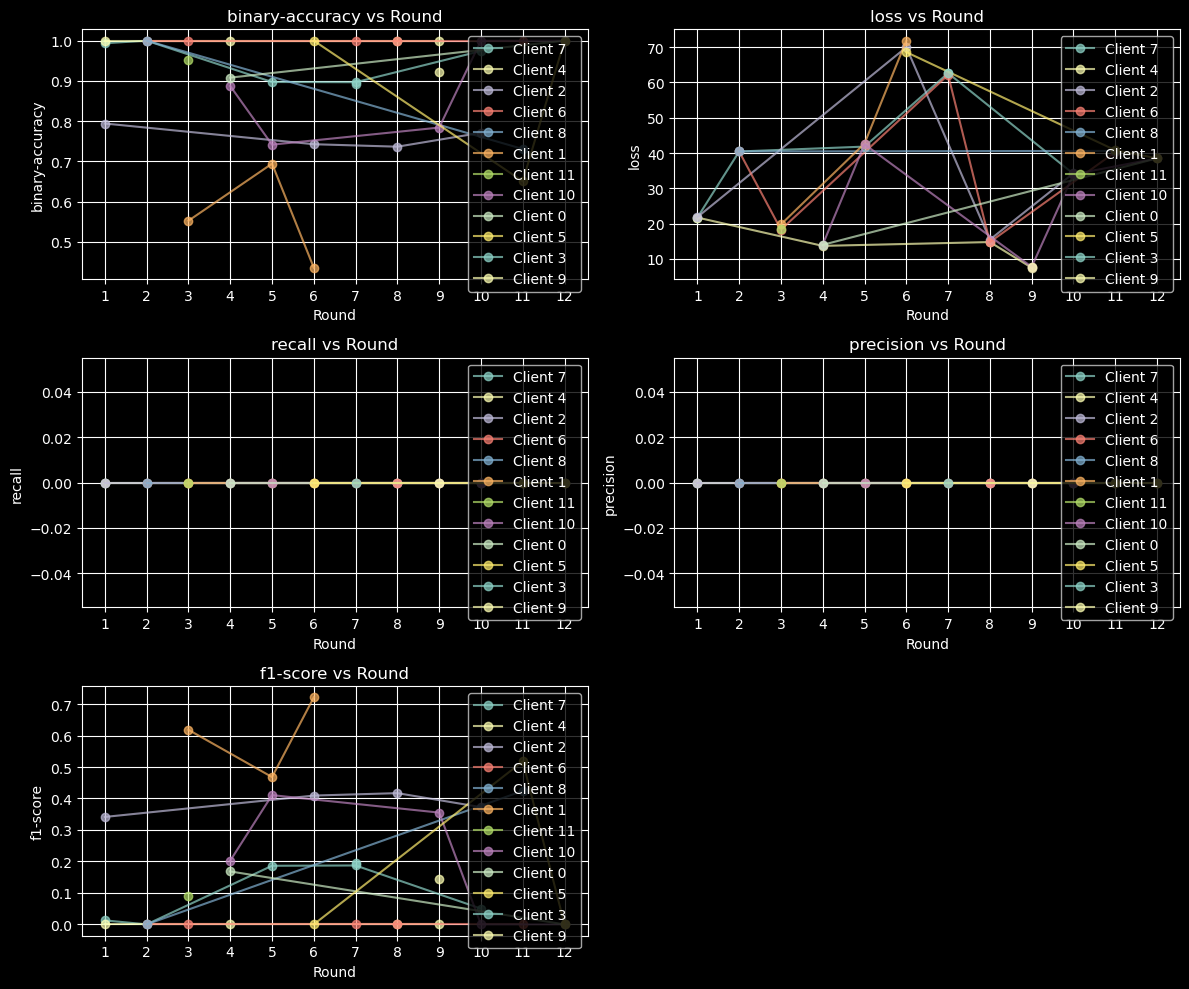

In [16]:
import matplotlib.pyplot as plt

# List of metrics to plot
metrics_to_plot = ['binary-accuracy', 'loss', 'recall', 'precision', 'f1-score']

def plot_round_metrics_per_client(data: pd.DataFrame) -> None:
    # Create a figure with subplots for each metric
    plt.figure(figsize=(12, 10))

    # Loop through each metric and plot its values vs. rounds
    for idx, metric in enumerate(metrics_to_plot, 1):
        plt.subplot(3, 2, idx)  
        for client_id in data[client_id_key].unique():
            # Filter data for the current client_id
            client_data = data[data[client_id_key] == client_id]
            plt.plot(client_data[current_round_key], client_data[metric], label=f'Client {client_id}', marker='o', alpha=0.7)
        
        plt.title(f'{metric} vs Round')
        plt.xlabel('Round')
        plt.ylabel(metric)
        plt.grid(True)
        plt.xticks(ticks=range(1,df[current_round_key].max() + 1))
        plt.legend()

    plt.tight_layout()
    plt.show()


plot_round_metrics_per_client(pd.DataFrame(federated_server.evaluate_results))

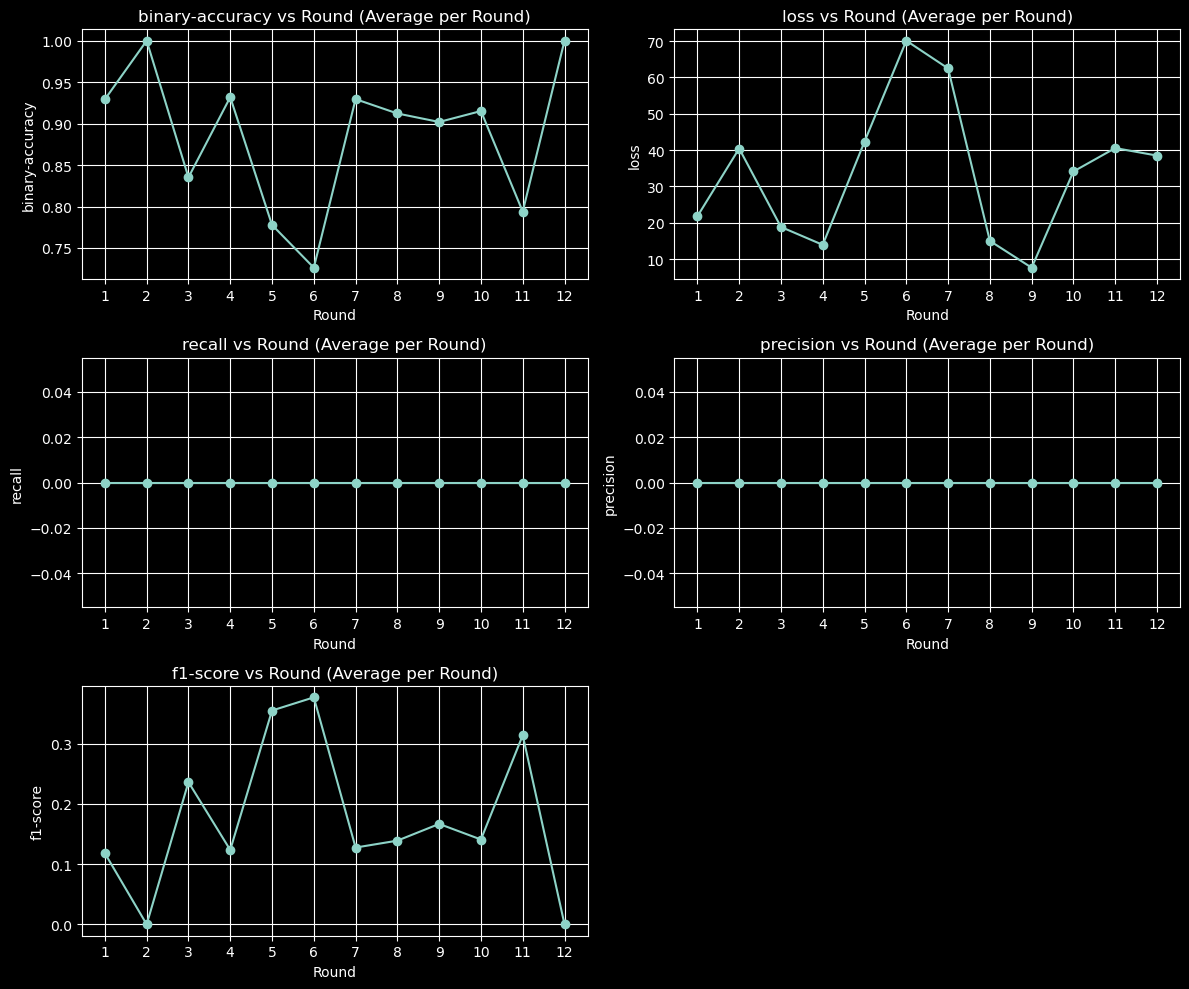

,0
anomaly-percentage,0.057573
binary-accuracy,0.887744
client-id,5.444444
f1-score,0.174799
loss,33.815091
precision,0.000000
recall,0.000000


In [17]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_round_metrics(data: pd.DataFrame) -> None:
    # Calculate the average of each metric per round
    avg_metrics_per_round = df.groupby(current_round_key)[metrics_to_plot].mean()


    # Plot the average values for each metric
    plt.figure(figsize=(12, 10))

    for idx, metric in enumerate(metrics_to_plot, 1):
        plt.subplot(3, 2, idx)  # Create a 3x2 grid of subplots
        plt.plot(avg_metrics_per_round.index, avg_metrics_per_round[metric], marker='o', label=f'Average {metric}')
        plt.title(f'{metric} vs Round (Average per Round)')
        plt.xlabel('Round')
        plt.xticks(ticks=range(1,df[current_round_key].max() + 1))
        plt.ylabel(metric)
        plt.grid(True)

    plt.tight_layout()
    plt.show()
    

plot_round_metrics(pd.DataFrame(federated_server.evaluate_results))
pd.DataFrame(df.groupby(client_id_key)[metrics_to_plot].mean())
pd.DataFrame(df.groupby(current_round_key)[metrics_to_plot].mean())
pd.DataFrame(df.groupby(current_round_key).mean().mean())